# Modern Portfolio Theory (MPT)

## Higher Dimensional Efficient Frontier

In [73]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
%matplotlib inline
sns.set(palette = 'bright',color_codes=True)
from mpl_toolkits.mplot3d import Axes3D
plt.style.use('dark_background')
from IPython.core.pylabtools import figsize
figsize(12.0, 8.0)

start = datetime.datetime(2015,1,1)
end = datetime.date.today()

import sys
sys.path.insert(0, '../../scripts/')

from database import Stock
tickers = ['TTWO', '7CD.F', 'GME']

In [67]:
tmp_ = dict()
for tic in tickers:
    stk = Stock(tic, start, end).df
    tmp_[tic] = stk["Close"]
stocks = pd.DataFrame(tmp_)    

In [68]:
log_ret = np.log(stocks/stocks.shift(1))
log_ret = log_ret.dropna()
log_ret

,TTWO,7CD.F,GME
Date,,,
2018-06-19,-0.023982,-0.075941,0.035165
2018-06-20,0.001526,-0.005043,-0.002075
2018-06-21,-0.012878,0.002657,-0.011843
2018-06-22,0.003941,-0.030175,-0.000701
2018-06-25,-0.001968,0.045973,-0.026289
...,...,...,...
2021-02-08,0.027804,-0.036795,-0.060938
2021-02-09,-0.063021,-0.046415,-0.176141
2021-02-10,-0.002449,-0.013619,0.017536


In [69]:
def coskew(df):
    
    # Number of stocks
    num = len(df.columns)
    
    # Two dimionsal matrix for tensor product 
    mtx = np.zeros(shape = (len(df), num**2))
    
    v = df.values
    means = v.mean(0,keepdims=True)
    v1 = (v-means).T
    
    for i in range(num):
        for j in range(num):
                vals = v1[i]*v1[j]
                mtx[:,(i*num)+j] = vals/float((len(df)-1)*df.iloc[:,i].std()*df.iloc[:,j].std())
    
    #coskewness matrix
    m3 = np.dot(v1,mtx)
    
    #Normalize by dividing by standard deviation
    for i in range(num**2):
        use = i%num
        m3[:,i] = m3[:,i]/float(df.iloc[:,use].std())
    
    return m3

m3 = coskew(log_ret)

In [70]:
def cokurt(df):
    # Number of stocks
    num = len(df.columns)
    
    #First Tensor Product Matrix
    mtx1 = np.zeros(shape = (len(df), num**2))
    
    #Second Tensor Product Matrix
    mtx2 = np.zeros(shape = (len(df), num**3))
    
    v = df.values
    means = v.mean(0,keepdims=True)
    v1 = (v-means).T

    for k in range(num):
        for i in range(num):
            for j in range(num):
                    vals = v1[i]*v1[j]*v1[k]
                    mtx2[:,(k*(num**2))+(i*num)+j] = vals/float((len(df)-1)*df.iloc[:,i].std()*\
                                                                df.iloc[:,j].std()*df.iloc[:,k].std())

    m4 = np.dot(v1,mtx2)
    for i in range(num**3):
        use = i%num
        m4[:,i] = m4[:,i]/float(df.iloc[:,use].std())
        
    return m4
    
m4 = cokurt(log_ret)

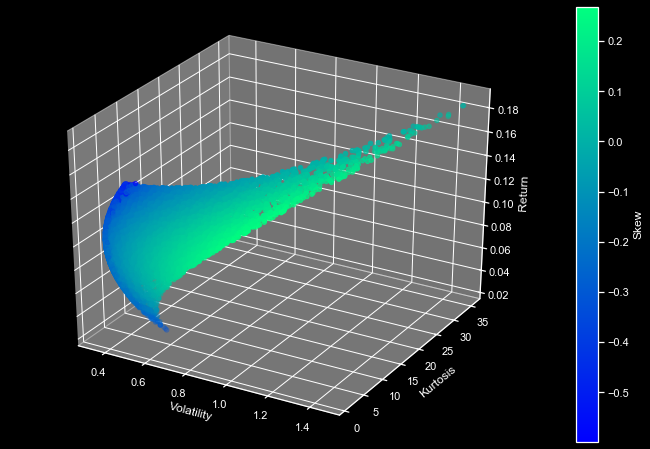

In [74]:
def ef(stocks, log_ret, m3, m4):    
    
    np.random.seed(10)
    trials = 10000
    all_weights = np.zeros((trials, len(stocks.columns)))
    
    ret_arr = np.zeros(trials)
    vol_arr = np.zeros(trials)
    coskew_arr = np.zeros(trials)
    cokurt_arr = np.zeros(trials)

    for i in range(trials):
        
        # Get random weights and store in weight array
        weights = np.array(np.random.random(len(stocks.columns)))
        weights = weights/np.sum(weights)
        all_weights[i,:] = weights

        # Expected return
        ret_arr[i] = np.sum( (log_ret.mean() * weights * 252))

        # Volatility
        vol_arr[i] = np.sqrt(np.dot(weights.T, np.dot(log_ret.cov()*252, weights)))

        # Coskew
        coskew_arr[i] = np.dot(weights.T, np.dot(m3,np.kron(weights,weights)))
        
        #Cokurtosis
        cokurt_arr[i] = np.dot(weights.T, np.dot(m4,np.kron(weights,np.kron(weights,weights))))
    
    fig = plt.figure()
    ax = plt.axes(projection='3d')
    a = ax.scatter(vol_arr, cokurt_arr, ret_arr, c=coskew_arr, cmap='winter')
    a = fig.colorbar(a, label = 'Skew')
    ax.set_xlabel('Volatility')
    ax.set_ylabel('Kurtosis')
    ax.set_zlabel('Return')

    return vol_arr, ret_arr, cokurt_arr, coskew_arr
    
vol_arr, ret_arr, cokurt_arr, coskew_arr = ef(stocks,log_ret, m3, m4)

Text(0, 0.5, 'Return')

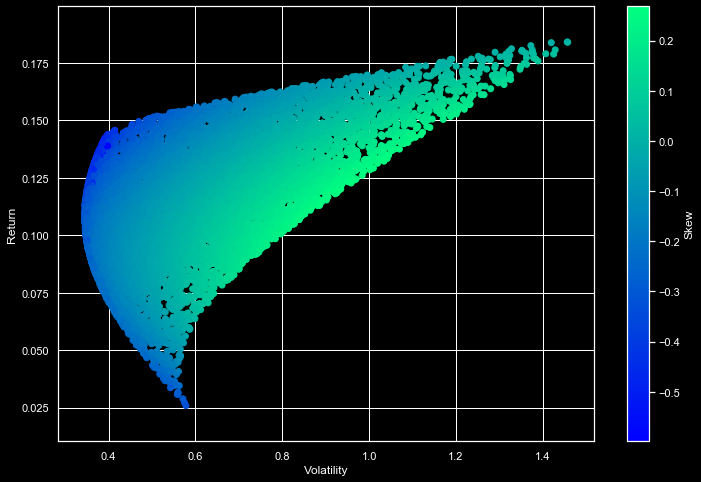

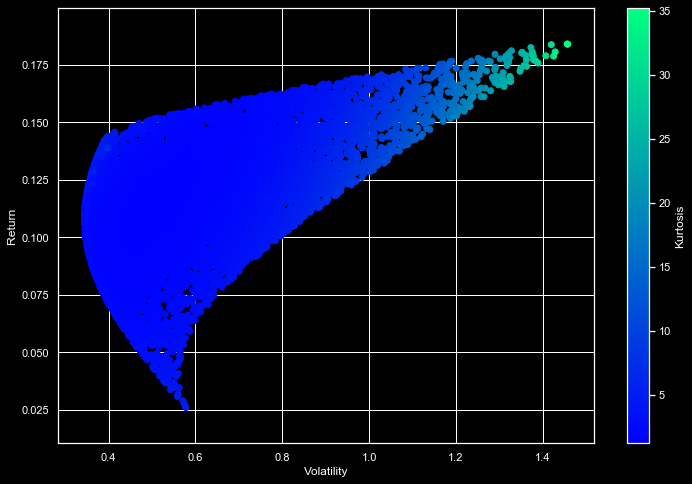

In [75]:
#Plot EF with skew cmap
plt.figure()
plt.scatter(vol_arr, ret_arr, c=coskew_arr, cmap='winter')
plt.colorbar(label='Skew')
plt.xlabel('Volatility')
plt.ylabel('Return')

#Plot EF with Kurt cmap
plt.figure()
plt.scatter(vol_arr, ret_arr, c=cokurt_arr, cmap='winter')
plt.colorbar(label='Kurtosis')
plt.xlabel('Volatility')
plt.ylabel('Return')